In [1]:
%matplotlib notebook

In [2]:
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as N
import scipy as S
import _projections_with_introspection as P
import scipy.optimize as SO
import scipy.linalg as SL
import experiment_generation as EG

In [4]:
def real_params_to_herm_matrix(vec):
    d = int(sqrt(len(vec)))
    matreal = vec.reshape(d,d)
    hermite = matreal + matreal.T + 1j * (matreal - matreal.T)
    return hermite / 2

def herm_matrix_to_real_params(mat):
    return (mat.real + mat.imag).ravel()

<h2> The dual function and its gradient </h2>

In [5]:
def dual_loss(nu, Phi_LS):
    """
    Computes the function to be minimized as the dual of the projection problem, with:
    Phi_LS: the matrix to project
    nu: the Lagrange multiplier (to be optimised upon).

    Returns minus the dual loss, and minus the gradient.
    """
    d = int(N.sqrt(len(Phi_LS)))
    partial_mixed = N.eye(d) / d
    numat = real_params_to_herm_matrix(nu)
    Phi_corr = Phi_LS - N.einsum('de, fg -> dfeg',partial_mixed, numat).reshape(d**2,d**2) / 2

    Phi = P.proj_CP_threshold(Phi_corr, free_trace=True)
    
    quad = SL.norm(Phi - Phi_LS)**2
    
    constraint = herm_matrix_to_real_params(N.trace(Phi.reshape(4 * [d]), axis1=0, axis2=2) - partial_mixed) / d
    
    price = N.dot(constraint, nu)
    
    jacobian = constraint

    return - quad - price, - jacobian

<h2> Same, with possible logging of least eigenvalues of TP projections, for comparison. </h2>

In [6]:
def dual_loss_global_least_ev(nu, Phi_LS):
    """
    Version of dual_loss that also computes the least eigenvalue of the projection on the trace-preserving
    channels, as a global variable, to allow storage and comparison with other methods. Twice as long as
    with no log.
    """

    global lev_jac
    global current_cost
    
    d = int(N.sqrt(len(Phi_LS)))
    partial_mixed = N.eye(d) / d
    numat = real_params_to_herm_matrix(nu)
    Phi_corr = Phi_LS - N.einsum('de, fg -> dfeg',partial_mixed, numat).reshape(d**2,d**2) / 2

    Phi = P.proj_CP_threshold(Phi_corr, free_trace=True)
    
    # Here is the record, doubling time.
    lev_jac = SL.eigvalsh(P.proj_TP(Phi), subset_by_index=[0,0])
    
    quad = SL.norm(Phi - Phi_LS)**2
    
    constraint = herm_matrix_to_real_params(N.trace(Phi.reshape(4 * [d]), axis1=0, axis2=2) - partial_mixed) / d
    # Je comprends toujours pas ces normalisations
    price = N.dot(constraint, nu)
    
    jacobian = constraint

    current_cost = - quad - price
    
    return current_cost, - jacobian



def log_cost_and_evs(x):
    cost_values.append(current_cost)
    levs_jac.append(lev_jac)

<h2> We rebuild the same least-square estimator as used by the other methods in Figure 5 of the article </h2>

In [7]:
fileh = EG.tables.open_file(f'article_experiments/compare_QFT_1e7.h5','r')
rooth = fileh.get_node('/')

true_Choi = EG.Choi(N.array(rooth.kraus_true_channel))
probas = EG.probas_Pauli(5, N.array(rooth.kraus_true_channel))

k = 5
cycles = rooth.summary.attrs.cycles
def Choi_LS():
                    freq, sample_size = EG.sampling(probas, cycles, full_output=1)
                    return EG.Choi_LS_from_Pauli_freq(k, freq), sample_size
        
N.random.set_state(rooth.summary.attrs.RandomState)        
rho, sample_size = Choi_LS()
rhoCP, LS_least_ev = EG.proj_CP_threshold(rho, full_output=True, thres_least_ev=True)

<h3> Quick check that we did not go wrong: should be the same least eigenvalue [NOT STABLE; WORKS ON THE SAME COMPUTER AS THE ORIGINAL EXPERIMENTS]</h3>

In [8]:
LS_least_ev, rooth.exp_repet0.initialisation.cols.LS_least_ev[:]

(-0.062052410933560086, array([-0.06205241]))

<h1> Simulation of the projection via the dual </h1>

In [18]:
cost_values = []
levs_jac = []

res_jac_g = SO.minimize(dual_loss_global_least_ev, zeros(2**10), args=(rho,), jac=True, tol=2e-15, callback=log_cost_and_evs, options={'maxiter':300})

In [20]:
res_jac_g

      fun: -0.9728854002119146
 hess_inv: array([[183.48840516,  12.60586286,  -5.50013659, ..., -57.30422056,
        -64.93941041, 124.05410487],
       [ 12.60586286,  58.65581235,   3.29382528, ...,   4.17298963,
         19.39566721,  -5.84114424],
       [ -5.50013659,   3.29382528, 137.77818898, ...,  28.86581269,
          8.00096656,  11.29116746],
       ...,
       [-57.30422056,   4.17298963,  28.86581269, ..., 286.91499879,
         -5.99105404,  48.54586338],
       [-64.93941041,  19.39566721,   8.00096656, ...,  -5.99105404,
        150.74163451, -85.58835264],
       [124.05410487,  -5.84114424,  11.29116746, ...,  48.54586338,
        -85.58835264, 203.44808641]])
      jac: array([ 1.75331133e-10, -1.22486457e-10, -6.92210091e-11, ...,
        5.89714469e-10,  5.03404434e-11, -1.88286017e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit: 186
     njev: 208
   status: 2
  success: False
        x: array([ 3.63390

# Pour la figure

In [11]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True

mpl.rcParams['grid.linestyle'] = 'dotted'

mpl.rcParams['font.size'] = 12

mpl.rcParams['figure.titlesize'] = 16

In [12]:
tolcolors_med_contrast={
'ly': '#EECC66',
'lr': '#EE99AA',
'lb': '#6699CC',
'dy': '#997700',
'dr': '#994455',
'db': '#004488',    
}
custom_cycler = (cycler(color=[tolcolors_med_contrast[ss] for ss in ['db', 'dy', 'lr', 'lb', 'ly', 'dr']]))

<IPython.core.display.Javascript object>


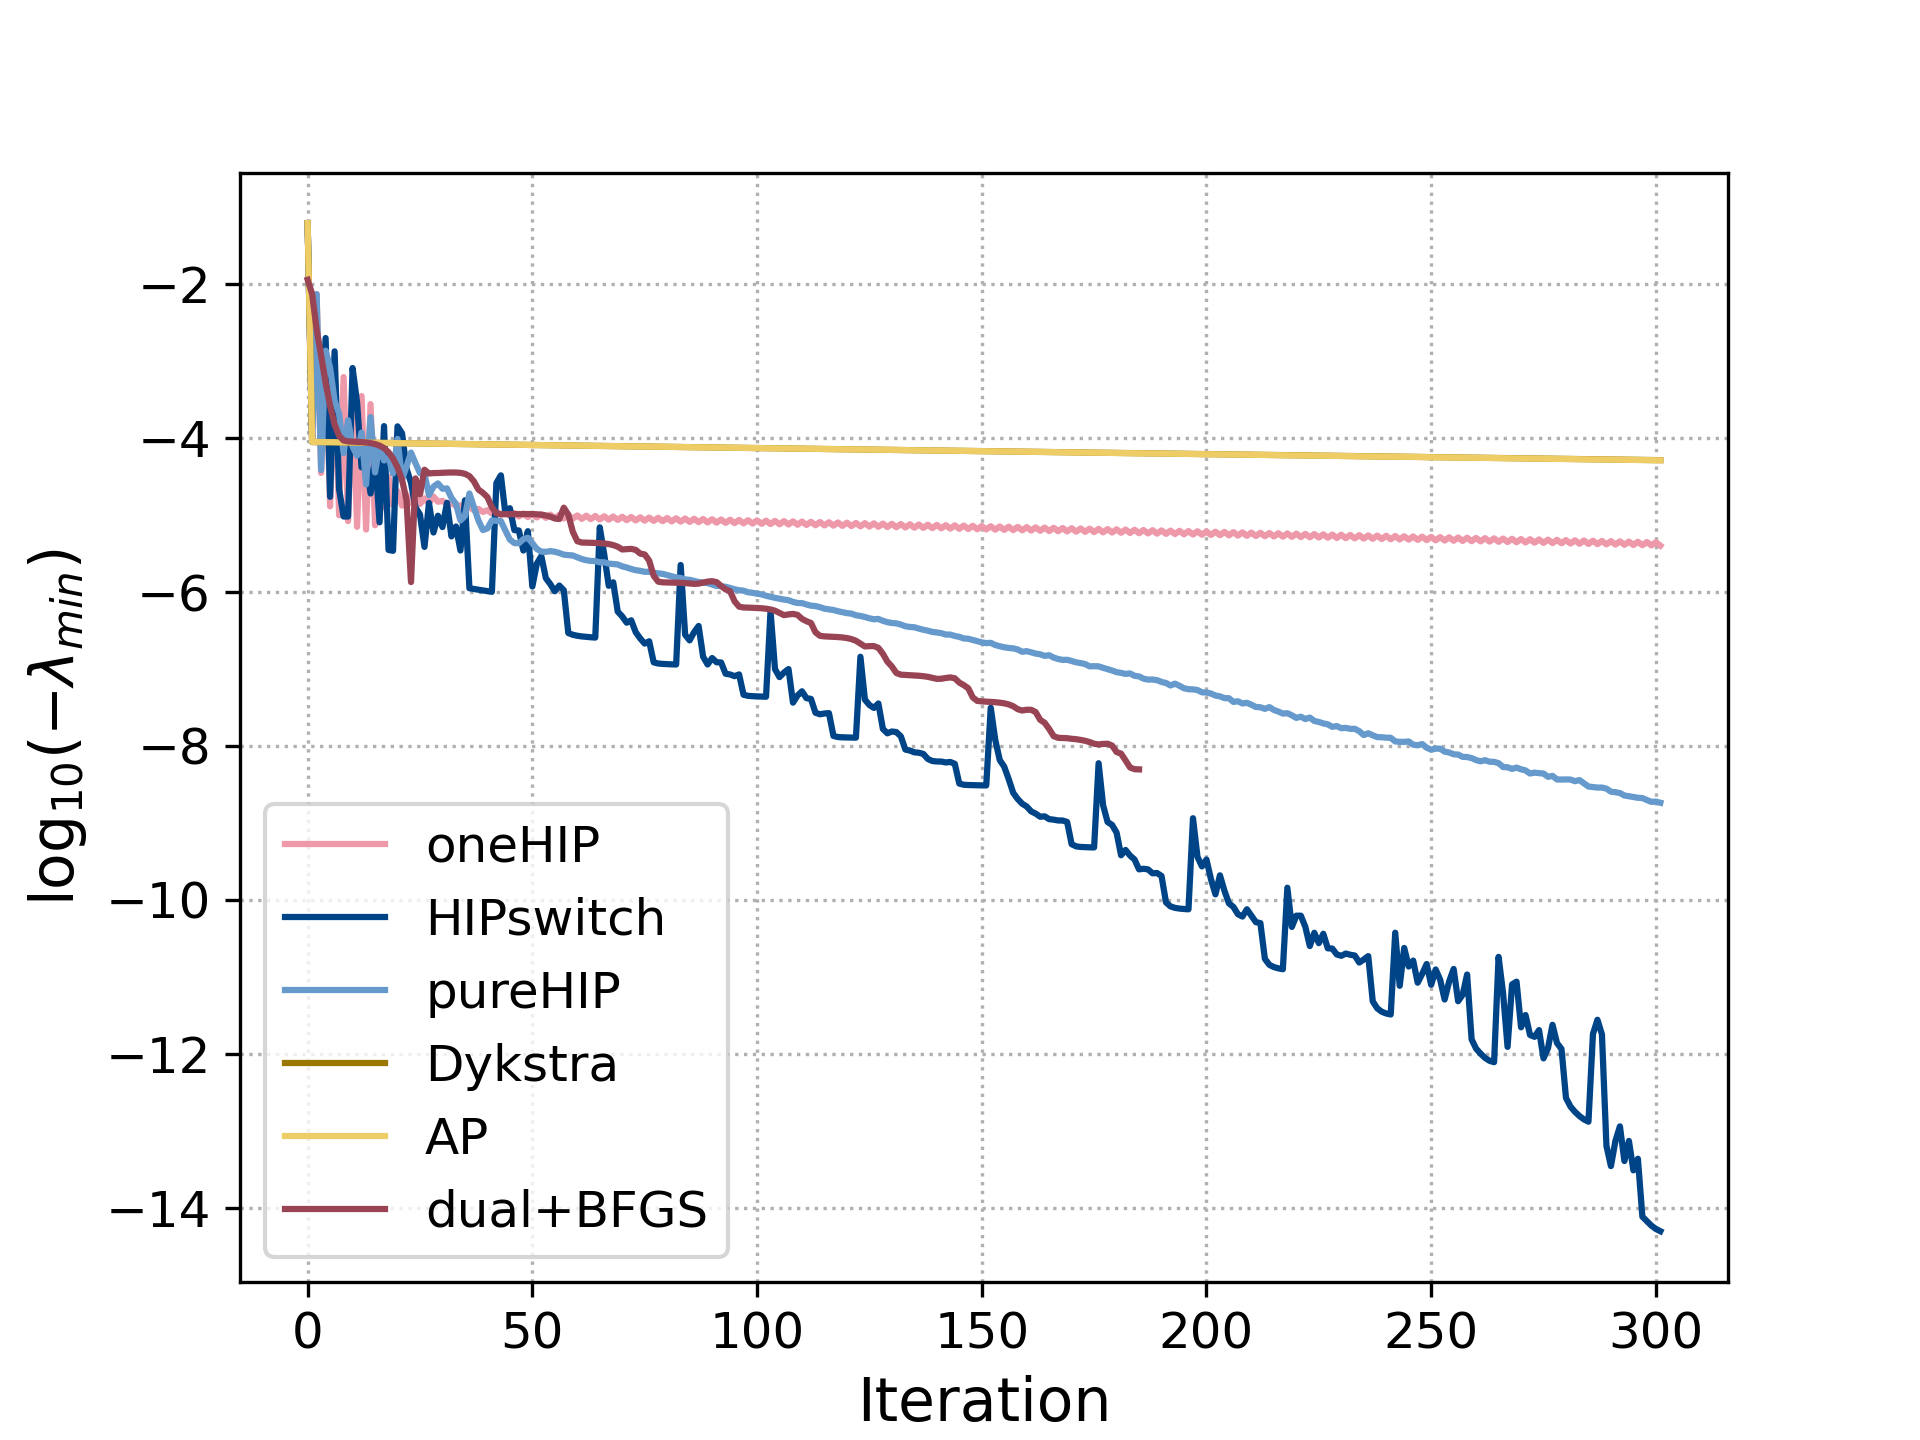

In [19]:
spec_custom_cycler = (cycler(color=[tolcolors_med_contrast[ss] for ss in ['lr', 'db', 'lb', 'dy', 'ly', 'dr']]))

fig, axes = subplots(dpi=300)
axes.set_prop_cycle(spec_custom_cycler)
#for proj in ['HIPswitch','Dykstra','Alternate','pureHIP','oneHIP']:
for proj in ['oneHIP', 'HIPswitch', 'pureHIP', 'Dykstra','Alternate']:
        ex = EG.retrieve_main(f'article_experiments/compare_QFT_1e7.h5', proj_type=proj)
        if proj=='Alternate':
            proj='AP'
        plot(np.log10(-ex['least_ev']), label=proj)#, linewidth=1)

plot(np.log10(-array(levs_jac)), label='dual+BFGS')        

axes.set_ylabel("$\log_{10}(-\lambda_{min})$", fontsize='large')

axes.set_xlabel("Iteration", fontsize='large')

axes.legend()
